# 📦 1. Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import nltk
import re

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score, calinski_harabasz_score, homogeneity_score
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from sentence_transformers import SentenceTransformer

nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

sns.set(style="whitegrid")
seed = 10


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rayspring\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rayspring\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 📁 2. Load the Dataset


In [83]:
df = pd.read_csv("musicLyrics.csv")

df = df.dropna(subset=['Lyric'])
df = df.reset_index(drop=True)
df.head()

,Lyric
0,Cryptic psalms Amidst the howling winds A scor...
1,Im sleeping tonight with all the wolves Were d...
2,Wings of the darkest descent Fall from the rea...
3,[Verse 1] Norrid Radd was my real name Had a j...
4,Deep in the dungeons of doom and despair Sneak...


# 🧹 3. Preprocessing and Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()
custom_stopwords = set(ENGLISH_STOP_WORDS) - {'never', 'always', 'heart', 'love'}  

def preprocess(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"dont", "do not", text)
    text = re.sub(r"cant", "cannot", text)
    text = re.sub(r"[^a-z\s]", "", text)

    tokens = text.split()
    tokens = [word for word in tokens if word not in custom_stopwords]
    tokens = [lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in tokens]
    return " ".join(tokens)

df["clean_lyrics"] = df["Lyric"].apply(preprocess)
df.head()


,Lyric,clean_lyrics
0,Cryptic psalms Amidst the howling winds A scor...,cryptic psalm amidst howl wind scorch source a...
1,Im sleeping tonight with all the wolves Were d...,sleep tonight wolves dream life thats better p...
2,Wings of the darkest descent Fall from the rea...,wing darkest descent fall realm dark blackest ...
3,[Verse 1] Norrid Radd was my real name Had a j...,norrid radd real job hat day day tell boss jus...
4,Deep in the dungeons of doom and despair Sneak...,deep dungeons doom despair sneak place dark ek...


# 🧠 4. Feature Extraction using Sentence Transformers

In [85]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df["clean_lyrics"].tolist(), batch_size=32, show_progress_bar=True)


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

# 📉 5. Elbow Method for K-Means

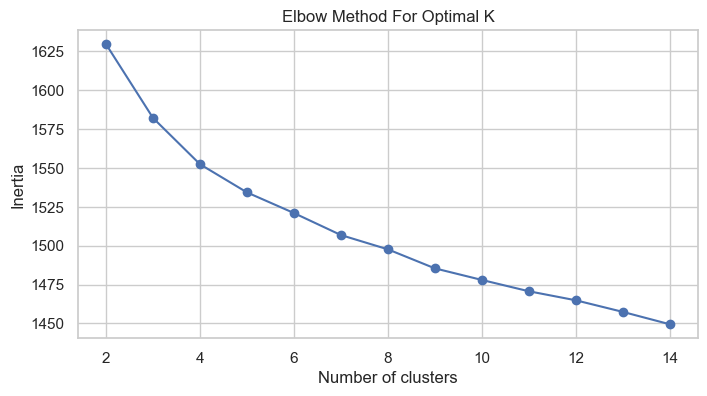

In [86]:
inertia = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method For Optimal K")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

# 🧵 6. Apply Clustering Methods

In [ ]:
eps_values = [0.1, 0.15, 0.2, 0.25, 0.3]
min_samples_values = [5, 8, 10, 15]
best_eps, best_min_samples = 0.2, 8 
best_silhouette = -1
best_labels = None

for eps in tqdm(eps_values, desc="Tuning eps"):
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = dbscan.fit_predict(embeddings)
        if len(set(labels)) > 1:
            sil_score = silhouette_score(embeddings, labels)
            if sil_score > best_silhouette:
                best_silhouette = sil_score
                best_eps, best_min_samples = eps, min_samples
                best_labels = labels
        print(f"eps={eps}, min_samples={min_samples}, Clusters={len(set(labels))-1 if -1 in labels else len(set(labels))}, Silhouette={sil_score if len(set(labels)) > 1 else 'N/A'}")

print(f"Best DBSCAN Parameters: eps={best_eps}, min_samples={best_min_samples}, Silhouette={best_silhouette:.4f}")
df['dbscan'] = best_labels

Tuning eps:  20%|██        | 1/5 [00:00<00:00,  4.52it/s]

eps=0.1, min_samples=5, Clusters=0, Silhouette=N/A
eps=0.1, min_samples=8, Clusters=0, Silhouette=N/A
eps=0.1, min_samples=10, Clusters=0, Silhouette=N/A
eps=0.1, min_samples=15, Clusters=0, Silhouette=N/A
eps=0.15, min_samples=5, Clusters=1, Silhouette=-0.07427182793617249
eps=0.15, min_samples=8, Clusters=1, Silhouette=-0.07549391686916351


Tuning eps:  40%|████      | 2/5 [00:00<00:01,  2.35it/s]

eps=0.15, min_samples=10, Clusters=1, Silhouette=-0.07654020190238953
eps=0.15, min_samples=15, Clusters=0, Silhouette=N/A
eps=0.2, min_samples=5, Clusters=1, Silhouette=-0.040869660675525665
eps=0.2, min_samples=8, Clusters=1, Silhouette=-0.041366059333086014


Tuning eps:  60%|██████    | 3/5 [00:01<00:01,  1.82it/s]

eps=0.2, min_samples=10, Clusters=1, Silhouette=-0.04395703598856926
eps=0.2, min_samples=15, Clusters=1, Silhouette=-0.04585355147719383
eps=0.25, min_samples=5, Clusters=4, Silhouette=-0.06363161653280258
eps=0.25, min_samples=8, Clusters=1, Silhouette=-0.0019041616469621658


Tuning eps:  80%|████████  | 4/5 [00:02<00:00,  1.66it/s]

eps=0.25, min_samples=10, Clusters=1, Silhouette=-0.001828930340707302
eps=0.25, min_samples=15, Clusters=1, Silhouette=-0.001938646542839706
eps=0.3, min_samples=5, Clusters=1, Silhouette=0.029574066400527954
eps=0.3, min_samples=8, Clusters=1, Silhouette=0.028374116867780685


Tuning eps: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

eps=0.3, min_samples=10, Clusters=1, Silhouette=0.027922702953219414
eps=0.3, min_samples=15, Clusters=1, Silhouette=0.026866646483540535
Best DBSCAN Parameters: eps=0.3, min_samples=5, Silhouette=0.0296


In [88]:
kmeans = KMeans(n_clusters=3, random_state=seed, n_init=30).fit(embeddings)
# dbscan = DBSCAN(eps=0.7, min_samples=30).fit(embeddings)
hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(embeddings)

df["kmeans"] = kmeans.fit_predict(embeddings)
# df["dbscan"] = dbscan.fit_predict(embeddings)
df["hierarchical"] = hierarchical.fit_predict(embeddings)

# 📊 7. Dimensionality Reduction with PCA

In [89]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

df["pca1"] = reduced[:, 0]
df["pca2"] = reduced[:, 1]


# 🖼️ 8. Visualize Clusters

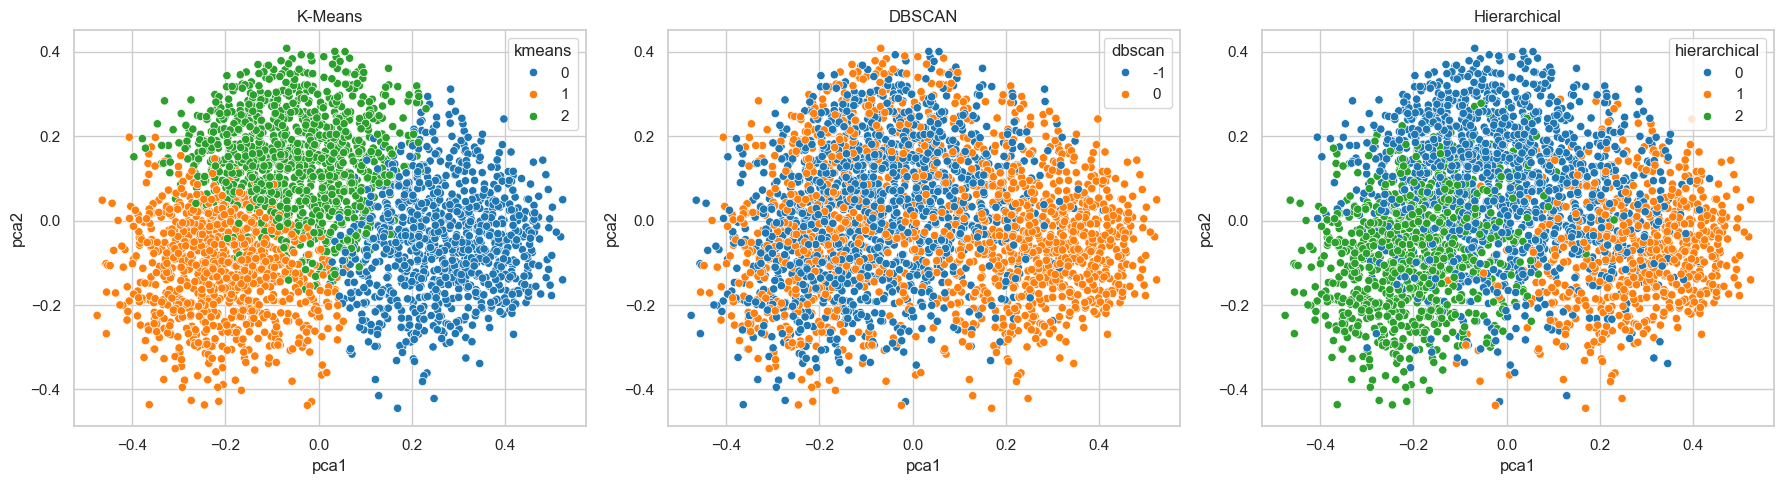

In [90]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=df, x="pca1", y="pca2", hue="kmeans", ax=axes[0], palette="tab10").set_title("K-Means")
sns.scatterplot(data=df, x="pca1", y="pca2", hue="dbscan", ax=axes[1], palette="tab10").set_title("DBSCAN")
sns.scatterplot(data=df, x="pca1", y="pca2", hue="hierarchical", ax=axes[2], palette="tab10").set_title("Hierarchical")
plt.tight_layout()
plt.show()


# 📏 9. Evaluation Metrics

In [91]:
print("Silhouette Scores:")
print("KMeans:", silhouette_score(embeddings, df["kmeans"]))
print("DBSCAN:", silhouette_score(embeddings, df["dbscan"]) if len(set(dbscan.labels_)) > 1 else "N/A")
print("Hierarchical:", silhouette_score(embeddings, df["hierarchical"]))

print("\nHomogeneity Scores (simulate with clusters as pseudo-labels):")
print("KMeans:", homogeneity_score(df["kmeans"], kmeans.labels_))
print("DBSCAN:", homogeneity_score(df["dbscan"], dbscan.labels_))
print("Hierarchical:", homogeneity_score(df["hierarchical"], hierarchical.labels_))


Silhouette Scores:
KMeans: 0.05142551
DBSCAN: 0.029574066
Hierarchical: 0.025566319

Homogeneity Scores (simulate with clusters as pseudo-labels):
KMeans: 1.0
DBSCAN: 0.8305896971211495
Hierarchical: 1.0


# 📚 10. Sample Lyrics from Each Cluster

In [92]:
def show_samples(label_column):
    print(f"Samples from clustering using {label_column}:")
    for cluster in sorted(df[label_column].unique()):
        samples = df[df[label_column] == cluster]["Lyric"].head(2).values
        print(f"\nCluster {cluster}:")
        for i, sample in enumerate(samples):
            print(f"  Sample {i+1}:\n    {sample[:200]}...")

show_samples("kmeans")


Samples from clustering using kmeans:

Cluster 0:
  Sample 1:
    Dont look at me that way Like you know how its going to end.. Cause am........too tired to be honest [Verse 1 Th3 Ghost] I hope me and money be in holy matrimony And on our moneymoon We will have fun ...
  Sample 2:
    a parody of Sir MixALots song Baby Got Back I feel sick and I just might die And I honestly dont know why But when my doc walked in with a huge seringe And a big grin on his face I passed out Which do...

Cluster 1:
  Sample 1:
    Cryptic psalms Amidst the howling winds A scorching source of agonizing bliss Beneath its veil Mysteries of a life beyond Can you hear it? Sons and daughters with hearts ablaze Forsaken ones in deaths...
  Sample 2:
    Wings of the darkest descent Fall from the realm of dark From the blackest fall of creation Doomed by its end Winds of chaos blow through my soul Wings of the darkest descent shall fall Lurking evil s...

Cluster 2:
  Sample 1:
    Im sleeping tonight with all t

# 📘 Theoretical Questions and Answers

## 🔍 Why is preprocessing necessary for textual data?
Preprocessing is essential to clean, normalize, and reduce noise in raw textual data. It helps in:
- Removing irrelevant characters or formatting.
- Standardizing text (e.g., lowercasing, lemmatizing).
- Reducing vocabulary size (e.g., removing stopwords).
- Enhancing the performance of downstream models.

## 🌱 Stemming vs. Lemmatization

| Feature       | Stemming           | Lemmatization        |
|---------------|--------------------|----------------------|
| Method        | Rule-based         | Dictionary-based     |
| Output        | Not always valid   | Valid words          |
| Accuracy      | Fast, less precise | Slower, more accurate |
| Example       | "running" → "runn" | "running" → "run"    |

## 🧠 Why is feature extraction important?
Text data is unstructured and non-numeric. Machine learning models, especially clustering algorithms, require numeric inputs. Feature extraction converts text into meaningful numerical vectors that capture semantic information, enabling clustering based on content similarity.

## 💠 What are feature vectors?
Feature vectors are numeric representations of textual data. Each dimension in the vector captures some aspect of the text’s meaning, structure, or context. These are used as inputs for clustering and other machine learning algorithms.

## 🧊 SentenceTransformers & MiniLM
**SentenceTransformers** is a library for producing high-quality sentence embeddings using transformer models.

**all-MiniLM-L6-v2** is a small, efficient model that generates 384-dimensional embeddings. It balances speed and performance, making it suitable for tasks like clustering.

## 🎯 Elbow Method in K-Means
The Elbow Method is used to determine the optimal number of clusters (**K**) by plotting the **inertia** (sum of squared distances from points to their assigned cluster centers) for various K values. The 'elbow' or bend in the plot indicates a good balance between model complexity and clustering accuracy.

## 📊 K-Means vs. DBSCAN vs. Hierarchical Clustering

| Algorithm     | Description | Pros | Cons |
|---------------|-------------|------|------|
| **K-Means**   | Partitions data into K clusters | Simple, efficient | Needs K, sensitive to noise |
| **DBSCAN**    | Groups dense areas of data | Detects outliers, no need for K | Poor for varying densities |
| **Hierarchical** | Builds nested clusters | Dendrograms, no K needed | Computationally expensive |

## 🧬 PCA (Principal Component Analysis)
PCA reduces the number of dimensions in the data while preserving variance. It helps to:
- Visualize high-dimensional vectors.
- Speed up computation.
- Remove noise.

## 🧪 Silhouette & Homogeneity Scores

- **Silhouette Score**: Measures how well samples fit within their cluster and how well-separated clusters are. Range: -1 (worst) to +1 (best).

- **Homogeneity Score**: Evaluates if all elements in a cluster belong to the same class. Useful when ground-truth labels are available.
